In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm as tq

# Build the Jellyfish structure

In [2]:
def construct_jellyfish_topology(switches, ports, r):
  
    #create switch structure
    G = nx.random_regular_graph(r, switches)
    
    #label switches with 0
    for i in range(switches):
        
        G.nodes[i]['type'] = 0 
    
    #add servers labeling them as 1

    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))
    H.add_edges_from(G.edges())
    
    servers_counter = 0
    
    for i in range(switches):

        for j in range(ports - r):
            
            if servers_counter <= n_servers:

                server_name = f'server_{i}_{j}'

                H.add_node(server_name)

                H.nodes[server_name]['type'] = 1

                H.add_edge(i, server_name)

                servers_counter += 1 
    
    return H

In [3]:
n = 64                           #number of ports
r = int(n/2)                     #number of neighbor
n_servers = (n**3)//4        #number of servers
n_switches = n_servers//(n-r)    #number of switches


# Construct Jellyfish topology
jelly = construct_jellyfish_topology(n_switches, n, r)


In [4]:
#constants

tau = 5*10**-6 
L_f = 4000 #in Gbit
f = 48/1500 #overhead
expected_time = 8 * 3600 #expected time in second
fixed_job_time_s = 30
L_0 = 4000
capacity = 10

In [5]:
def response_time(graph, N, tau, L_f, f, expected_time, fixed_job_time_s, L_0, capacity): 

  #get the list of servers
    servers = [node[0] for node in graph.nodes(data = True) if node[1]['type'] == 1] 

  #choose the main server
    main_server = random.choice(servers)

  #create a list of tuples with (server, number of hopes from the main_server)
    dict_hops = [(i,nx.shortest_path_length(graph, main_server, i)) for i in servers if i != main_server]

  #sort the server by closeness
    n_closest_servers = sorted(dict_hops,key = lambda x: x[1])

  #calculate the avg throughput
    avg_t = []

    closest_server_hopes = [i[1] for i in n_closest_servers[0:(n_servers)]]

    normalizing_term = sum(1/(2*tau*np.array(closest_server_hopes)))

    for i in closest_server_hopes:
    
        tj = 2*tau*i
        throughput = capacity * (1 / tj) / normalizing_term
        avg_t.append(throughput)

  #time forth
    input_data = np.full(n_servers - 1, (L_f/n_servers)) + ((L_f / n_servers) * f)

  #input_data = np.array([L_f/n_servers]) + ((L_f / n_servers) * f) #split data + overhead
    time_forth = input_data/np.array(avg_t) #time 

  #job time
    job_running_times = np.random.exponential(1/(expected_time/n_servers), n_servers - 1) + fixed_job_time_s

  #go back
    output_job = np.random.uniform(0, (2*L_0/n_servers), n_servers - 1)

    output_data = output_job + (output_job * f)

    time_to_back = output_data / np.array(avg_t)

    response_time = np.max(time_forth + job_running_times + time_to_back)

    return response_time 
  

In [6]:
response_time(jelly, 100, tau, L_f, f, expected_time, fixed_job_time_s, L_0, capacity)

1409.400302715796

In [ ]:
#simulation parameters

N = 10000  #maximum rumber of servers

servers = range(1, N + 1, 200)  #grid search on number of servers

baseline = expected_time + fixed_job_time_s

n_simulation = 5

responses = []

for number in tq(servers): 

    samples = []

    for _ in range(n_simulation):

        samples.append(response_time(jelly, number, tau, L_f, f, expected_time, fixed_job_time_s, L_0, capacity))

    responses.append(sum(samples)/(len(samples)))  



 32%|█████████████▊                             | 16/50 [05:30<12:03, 21.27s/it]

In [13]:
def plot_response_time(servers, response_times: [np.array], labels: [str],optimal_servers):
    """Plots the expected response time."""
    fig, ax = plt.subplots(1)

    for response_time, label, optimal_server in zip(response_times, labels, optimal_servers):
        ax.plot(servers, response_time, label=label)
        ax.axvline(x=optimal_server, ls="--", label="Optimal Servers")
        ax.text(x=optimal_server * 0.90, y=np.max(response_times), s=optimal_server)

    ax.set(title="Normalised Response Time", ylabel="Response Time", xlabel="Number of Servers")
    ax.legend()

    return fig, ax

In [15]:
len(servers)

50

In [16]:
len(responses)

250

In [ ]:
responses = np.array(responses[0:50])

plot_response_time(servers, responses, ["JellyFish"], [servers[np.argmin(responses)]])

ValueError: x and y must have same first dimension, but have shapes (50,) and (250,)

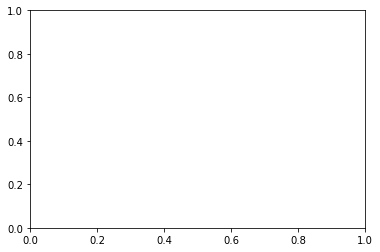

In [11]:

plt.plot(servers, np.array(responses) / baseline)
plt.xlabel("Number of Servers")
plt.ylabel("Responses time")
plt.title("Normalised Responses")
plt.show()

In [ ]:
def simulate_job_running_cost(n_servers, n_simulations):
    """
    According to the formula, in order to extract the expected value of the 
    response time and of theta, the function does a simulation in which it 
    uses the simulate_response_time function to calculate the response time and 
    it calculate the value of theta (sum of the times that all N servers are
    used to run their respective tasks). After that it extracts the mean and it
    returns the job running cost. 
    
    """
    sum_response_time = 0 
    sum_task_time = 0
    
    for _ in range(n_simulations): 
    
        sum_response_time += response_time(jelly, n_servers, tau, L_f, f, expected_time, fixed_job_time_s, L_0, capacity)
        
        task_time = 0
        
        for _ in range(n_servers):
            
            exec_times = np.random.exponential(expected_time / n_servers, n_servers)
            
            task_time += (fixed_job_time_s + exec_times)
            
        sum_task_time += task_time/n_servers
        
    job_running_cost = sum_response_time/n_simulations + (xi * (sum_task_time/n_simulations))
    
    return job_running_cost

In [ ]:
baseline = (expected_time + fixed_job_time_s) + (xi * expected_time)

In [ ]:
job_costs = []

    servers = range(1, N + 1, 100)

    for n_servers in tqdm(servers):
        
        job_cost = simulate_job_running_cost(n_servers, 10)
        
        job_costs.append(job_cost)
        
    """
    Plots
    """

    plt.plot(servers, np.array(job_costs) / baseline)
    plt.xlabel("Number of Servers")
    plt.ylabel("S")
    plt.title("Normalised Job Running Cost")
    plt.show()